This is a data from the accounting system of an e-commerce company for one whole year.
====

The task is to check the accounting data with ML

In [2]:
from datetime import datetime
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
pd.options.display.width = 0
pd.options.display.max_rows = None
pd.options.display.float_format = "{:.2f}".format

In [3]:
data = pd.read_csv('######', header=0, sep=';', thousands='.', decimal=',', low_memory=False)

In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362056 entries, 0 to 362055
Data columns (total 39 columns):
Konto                            362056 non-null int64
Belegdatum                       362056 non-null int64
BU-Schlüssel                     52583 non-null float64
Gegenkonto                       362056 non-null int64
Buchungstext                     357709 non-null object
Steuersatz                       362056 non-null float64
Belegfeld 1                      362056 non-null object
Umsatz Soll                      362056 non-null float64
Umsatz Haben                     362056 non-null float64
WKZ eingeg. Umsatz               362056 non-null object
Eingeg. Umsatz                   362056 non-null float64
Kurs                             362056 non-null float64
Stapel-Nr.                       362056 non-null object
BSNr                             362056 non-null int64
Herkunft-Kz                      362056 non-null object
Belegfeld 2                      42 non-null flo

In [5]:
print(data.head())

    Konto  Belegdatum  BU-Schlüssel  Gegenkonto Buchungstext  Steuersatz  \
0   14000     1012018           nan       90080      EB-Wert        0.00   
1   90080     1012018           nan      107000      EB-Wert        0.00   
2  107000     1012018           nan       90080      EB-Wert        0.00   
3   14000     1012018           nan       90080      EB-Wert        0.00   
4   90080     1012018           nan      110000      EB-Wert        0.00   

  Belegfeld 1  Umsatz Soll  Umsatz Haben WKZ eingeg. Umsatz  ...  \
0           0       699.02          0.00                EUR  ...   
1           0         0.00        699.02                EUR  ...   
2           0       699.02          0.00                EUR  ...   
3           0      2250.19          0.00                EUR  ...   
4           0         0.00       2250.19                EUR  ...   

   Gesellschaftername  Beteiligtennummer Identifikationsnummer  \
0                 nan                nan                   nan   
1 

Throwing out irrelevant features

In [6]:
irrelevant_features = ['WKZ eingeg. Umsatz', 'Stapel-Nr.', 'BSNr', 'Herkunft-Kz', 'Belegfeld 2', 'KOST1 - Kostenstelle', 
                       'KOST2 - Kostenstelle', 'Kost-Menge', 'Stück', 'Gewicht', 'Auftragsnummer', 'EU-Land (Anzahlungen)', 
                       'Sachverhalt L+L (Anzahlungen)', 'Gesellschaftername', 'Beteiligtennummer', 'Identifikationsnummer', 
                       'Zeichnernummer', 'Buchungs GUID', 'Bezeichnung SoBil-Sachverhalt', 'Kennzeichen SoBil-Buchung', 'Leistungsdatum', 'Datum Zuord. Steuerperiode']
data.drop(irrelevant_features, inplace=True, axis=1)

Adding datetime feature and if zero NaT.

In [7]:
data['new_date'] = pd.to_datetime(data['Belegdatum'].astype(str), format='%d%m%Y', errors='coerce')
data.head()

,Konto,Belegdatum,BU-Schlüssel,Gegenkonto,Buchungstext,Steuersatz,Belegfeld 1,Umsatz Soll,Umsatz Haben,Eingeg. Umsatz,Kurs,Buchungstyp (Anzahlungen),USt-Schlüssel (Anzahlungen),EU-Steuersatz (Anzahlungen),Erlöskonto (Anzahlungen),Skontotyp,Generalumkehr (GU),new_date
0,14000,1012018,nan,90080,EB-Wert,0.00,0,699.02,0.00,0.00,0.00,nan,0,nan,0,0,0,2018-01-10
1,90080,1012018,nan,107000,EB-Wert,0.00,0,0.00,699.02,0.00,0.00,nan,0,nan,0,0,0,2018-01-10
2,107000,1012018,nan,90080,EB-Wert,0.00,0,699.02,0.00,0.00,0.00,nan,0,nan,0,0,0,2018-01-10
3,14000,1012018,nan,90080,EB-Wert,0.00,0,2250.19,0.00,0.00,0.00,nan,0,nan,0,0,0,2018-01-10
4,90080,1012018,nan,110000,EB-Wert,0.00,0,0.00,2250.19,0.00,0.00,nan,0,nan,0,0,0,2018-01-10


In [8]:
# data[data['new_date'].isnull()]

Adding unixtime.

In [9]:
data['date_unix'] = (data['new_date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

In [10]:
data.head()

,Konto,Belegdatum,BU-Schlüssel,Gegenkonto,Buchungstext,Steuersatz,Belegfeld 1,Umsatz Soll,Umsatz Haben,Eingeg. Umsatz,Kurs,Buchungstyp (Anzahlungen),USt-Schlüssel (Anzahlungen),EU-Steuersatz (Anzahlungen),Erlöskonto (Anzahlungen),Skontotyp,Generalumkehr (GU),new_date,date_unix
0,14000,1012018,nan,90080,EB-Wert,0.00,0,699.02,0.00,0.00,0.00,nan,0,nan,0,0,0,2018-01-10,1515542400.00
1,90080,1012018,nan,107000,EB-Wert,0.00,0,0.00,699.02,0.00,0.00,nan,0,nan,0,0,0,2018-01-10,1515542400.00
2,107000,1012018,nan,90080,EB-Wert,0.00,0,699.02,0.00,0.00,0.00,nan,0,nan,0,0,0,2018-01-10,1515542400.00
3,14000,1012018,nan,90080,EB-Wert,0.00,0,2250.19,0.00,0.00,0.00,nan,0,nan,0,0,0,2018-01-10,1515542400.00
4,90080,1012018,nan,110000,EB-Wert,0.00,0,0.00,2250.19,0.00,0.00,nan,0,nan,0,0,0,2018-01-10,1515542400.00


In [11]:
# data['Konto'].unique()

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362056 entries, 0 to 362055
Data columns (total 19 columns):
Konto                          362056 non-null int64
Belegdatum                     362056 non-null int64
BU-Schlüssel                   52583 non-null float64
Gegenkonto                     362056 non-null int64
Buchungstext                   357709 non-null object
Steuersatz                     362056 non-null float64
Belegfeld 1                    362056 non-null object
Umsatz Soll                    362056 non-null float64
Umsatz Haben                   362056 non-null float64
Eingeg. Umsatz                 362056 non-null float64
Kurs                           362056 non-null float64
Buchungstyp (Anzahlungen)      0 non-null float64
USt-Schlüssel (Anzahlungen)    362056 non-null int64
EU-Steuersatz (Anzahlungen)    0 non-null float64
Erlöskonto (Anzahlungen)       362056 non-null int64
Skontotyp                      362056 non-null int64
Generalumkehr (GU)             362

**TASK 1**
---

Checking account 84000 Turnover if there are some bookings on the debit site

In [13]:
acc_84000 = data[data['Konto'] == 84000].count()
acc_84000

Konto                          32523
Belegdatum                     32523
BU-Schlüssel                      11
Gegenkonto                     32523
Buchungstext                   32523
Steuersatz                     32523
Belegfeld 1                    32523
Umsatz Soll                    32523
Umsatz Haben                   32523
Eingeg. Umsatz                 32523
Kurs                           32523
Buchungstyp (Anzahlungen)          0
USt-Schlüssel (Anzahlungen)    32523
EU-Steuersatz (Anzahlungen)        0
Erlöskonto (Anzahlungen)       32523
Skontotyp                      32523
Generalumkehr (GU)             32523
new_date                       32396
date_unix                      32396
dtype: int64

In [14]:
check_84000_soll = (data[(data['Konto'] == 84000) & (data['Umsatz Soll'] > 0)]).copy()

In [15]:
# check_84000_soll

In [16]:
check_84000_soll.describe()

,Konto,Belegdatum,BU-Schlüssel,Gegenkonto,Steuersatz,Umsatz Soll,Umsatz Haben,Eingeg. Umsatz,Kurs,Buchungstyp (Anzahlungen),USt-Schlüssel (Anzahlungen),EU-Steuersatz (Anzahlungen),Erlöskonto (Anzahlungen),Skontotyp,Generalumkehr (GU),date_unix
count,326.00,326.00,0.00,326.00,326.00,326.00,326.00,326.00,326.00,0.00,326.00,0.00,326.00,326.00,326.00,325.00
mean,84000.00,16425514.93,nan,111819.18,19.00,204.75,0.00,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,1526716711.38
std,0.00,8600654.54,nan,28193.81,0.00,1143.01,0.00,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,8946942.63
min,84000.00,1012018.00,nan,12000.00,19.00,0.01,0.00,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,1515542400.00
25%,84000.00,10012018.00,nan,120000.00,19.00,19.24,0.00,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,1519344000.00
50%,84000.00,17052018.00,nan,120000.00,19.00,44.45,0.00,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,1524009600.00
75%,84000.00,23022018.00,nan,120000.00,19.00,100.00,0.00,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,1532995200.00
max,84000.00,31122018.00,nan,126010.00,19.00,17875.56,0.00,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,1546214400.00


In [17]:
check_84000_soll['BU-Schlüssel'].unique()

array([nan])

In [18]:
check_84000_soll['Gegenkonto'].unique()

array([ 12000, 116010, 112030, 102020, 126010, 120000, 114010, 118020,
       106010, 107011,  15910, 108010, 112012], dtype=int64)

In [19]:
check_gegenkonto = check_84000_soll.groupby(['Gegenkonto']).count()
check_gegenkonto

,Konto,Belegdatum,BU-Schlüssel,Buchungstext,Steuersatz,Belegfeld 1,Umsatz Soll,Umsatz Haben,Eingeg. Umsatz,Kurs,Buchungstyp (Anzahlungen),USt-Schlüssel (Anzahlungen),EU-Steuersatz (Anzahlungen),Erlöskonto (Anzahlungen),Skontotyp,Generalumkehr (GU),new_date,date_unix
Gegenkonto,,,,,,,,,,,,,,,,,,
12000,23,23,0,23,23,23,23,23,23,23,0,23,0,23,23,23,23,23
15910,1,1,0,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1
102020,1,1,0,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1
106010,1,1,0,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1
107011,1,1,0,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1
108010,1,1,0,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1
112012,1,1,0,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1
112030,1,1,0,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1
114010,1,1,0,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1


In [20]:
check_84000_soll['Steuersatz'].unique()

array([19.])

In [21]:
check_belegfeld = check_84000_soll['Belegfeld 1']
# check_belegfeld

In [22]:
check_btext = check_84000_soll['Buchungstext']
# check_btext

In [23]:
check_stsatz = check_84000_soll['Steuersatz']
# check_stsatz

**TASK 2**
---


Anomaly detection of bookings on the account 84000 false on debet.

--- Preparing data

In [24]:
irr_v = ['Belegdatum', 'Eingeg. Umsatz', 'Kurs', 'new_date', 'Generalumkehr (GU)', 'BU-Schlüssel', 'Buchungstext', 
         'Belegfeld 1', 'Buchungstyp (Anzahlungen)', 'EU-Steuersatz (Anzahlungen)', 'Erlöskonto (Anzahlungen)', 'Skontotyp',
        'USt-Schlüssel (Anzahlungen)']
data_2 = data.drop(irr_v, axis=1)

In [25]:
data_2.head()

,Konto,Gegenkonto,Steuersatz,Umsatz Soll,Umsatz Haben,date_unix
0,14000,90080,0.00,699.02,0.00,1515542400.00
1,90080,107000,0.00,0.00,699.02,1515542400.00
2,107000,90080,0.00,699.02,0.00,1515542400.00
3,14000,90080,0.00,2250.19,0.00,1515542400.00
4,90080,110000,0.00,0.00,2250.19,1515542400.00


--- Adding conditions which booking is correct

In [26]:
data_2['acc_84000_corr1'] = (data_2['Konto'] == 84000) & (data_2['Umsatz Soll'] == 0)
data_2['acc_84000_corr1'] = data_2['acc_84000_corr1'].astype('int')

In [27]:
data_2['Steuersatz'].unique()

array([ 0. , 19. ,  7. , 20. , 13. , 10. ,  2.1, 21. ])

In [28]:
data_2 = data_2.drop(data_2[data_2['Steuersatz'] == 2.1].index)

In [29]:
data_2.head()

,Konto,Gegenkonto,Steuersatz,Umsatz Soll,Umsatz Haben,date_unix,acc_84000_corr1
0,14000,90080,0.00,699.02,0.00,1515542400.00,0
1,90080,107000,0.00,0.00,699.02,1515542400.00,0
2,107000,90080,0.00,699.02,0.00,1515542400.00,0
3,14000,90080,0.00,2250.19,0.00,1515542400.00,0
4,90080,110000,0.00,0.00,2250.19,1515542400.00,0


In [30]:
data_2_prep = data_2[data_2['Konto'] == 84000].reset_index()
throw_index = 'index'
data_2_prep = data_2_prep.drop(throw_index, axis=1)
# data_2_prep[data_2_prep['date_unix'].replace({pd.NaT: '1518480000.00'})]
data_2_prep = data_2_prep.fillna(1518480000.00)
data_2_prep.head()

,Konto,Gegenkonto,Steuersatz,Umsatz Soll,Umsatz Haben,date_unix,acc_84000_corr1
0,84000,12000,19.00,3.28,0.00,1515542400.00,0
1,84000,12000,19.00,3.28,0.00,1515542400.00,0
2,84000,12000,19.00,6.18,0.00,1515542400.00,0
3,84000,12000,19.00,6.55,0.00,1515542400.00,0
4,84000,12000,19.00,8.32,0.00,1515542400.00,0


In [31]:
data_2_prep.describe()

,Konto,Gegenkonto,Steuersatz,Umsatz Soll,Umsatz Haben,date_unix,acc_84000_corr1
count,32523.00,32523.00,32523.00,32523.00,32523.00,32523.00,32523.00
mean,84000.00,119852.17,19.00,2.00,58.16,1527503695.38,0.99
std,0.00,3690.51,0.00,116.18,217.60,9628328.46,0.10
min,84000.00,12000.00,19.00,-633.76,-1509.90,1515024000.00,0.00
25%,84000.00,120000.00,19.00,0.00,19.24,1518480000.00,1.00
50%,84000.00,120000.00,19.00,0.00,41.18,1525651200.00,1.00
75%,84000.00,120000.00,19.00,0.00,79.83,1536192000.00,1.00
max,84000.00,126010.00,19.00,17875.56,35486.50,1546214400.00,1.00


In [32]:
data_2_prep[data_2_prep.date_unix.isnull()]

,Konto,Gegenkonto,Steuersatz,Umsatz Soll,Umsatz Haben,date_unix,acc_84000_corr1


In [33]:
data_2_prep[(data_2_prep['acc_84000_corr1'] == 1)].count()
# print("How many bookings are correct on 84000:", check_y)

Konto              32193
Gegenkonto         32193
Steuersatz         32193
Umsatz Soll        32193
Umsatz Haben       32193
date_unix          32193
acc_84000_corr1    32193
dtype: int64

**Model 1**
* * *

- Isolation forest

In [57]:
from sklearn.model_selection import train_test_split
predict = 'acc_84000_corr1'

X = data_2_prep.drop([predict], axis=1)
y = data_2_prep[predict]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
scaler.transform(X_test)

array([[ 0.        ,  0.03908397,  0.        , -0.02540065,  0.56731883,
         1.83576576],
       [ 0.        ,  0.03908397,  0.        , -0.02540065, -0.49845235,
        -0.93249534],
       [ 0.        ,  0.03908397,  0.        , -0.02540065, -0.16576177,
         0.78418606],
       ...,
       [ 0.        ,  0.03908397,  0.        , -0.02540065,  0.28675549,
        -0.93249534],
       [ 0.        ,  0.03908397,  0.        , -0.02540065, -0.16576177,
        -0.34828439],
       [ 0.        ,  0.03908397,  0.        , -0.02540065, -0.37638223,
        -0.9414832 ]])

In [63]:
from sklearn.ensemble import IsolationForest

clf_if = IsolationForest(contamination=0.15, random_state=42, n_jobs=-1)
clf_if.fit(X_train[['Umsatz Soll']])

C:\Users\SZ\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=False, contamination=0.15,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=-1, random_state=42, verbose=0, warm_start=False)

In [64]:
some_X_test = X_test.iloc[150:185]
some_y_test = y_test.iloc[150:185]

some_pred = clf_if.predict(some_X_test[['Umsatz Soll']])
print("\nSome test predictions:\n", some_pred)
print("\nSome y_test:\n", list(some_y_test))


Some test predictions:
 [ 1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1]

Some y_test:
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


C:\Users\SZ\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [37]:
# predictions = clf_if.predict(X_test)


In [38]:
# confusion_matrix(y_test, predictions)

In [66]:
X_test['scores']=clf_if.decision_function(X_test[['Umsatz Soll']])
X_test['anomaly']=clf_if.predict(X_test[['Umsatz Soll']])
X_test.head(50)

C:\Users\SZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\SZ\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\Users\SZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Konto,Gegenkonto,Steuersatz,Umsatz Soll,Umsatz Haben,date_unix,scores,anomaly
31904,84000,120000,19.00,0.00,100.00,1545091200.00,0.05,1
5054,84000,120000,19.00,0.00,19.24,1518480000.00,0.05,1
23421,84000,120000,19.00,0.00,44.45,1534982400.00,0.05,1
30101,84000,120000,19.00,0.00,23.45,1544572800.00,0.05,1
10386,84000,120000,19.00,0.00,251.26,1519689600.00,0.05,1
1407,84000,120000,19.00,0.00,36.97,1516406400.00,0.05,1
12603,84000,120000,19.00,0.00,91.60,1520294400.00,0.05,1
19063,84000,120000,19.00,0.00,80.67,1526774400.00,0.05,1
28862,84000,120000,19.00,0.00,73.03,1541980800.00,0.05,1
22709,84000,120000,19.00,0.00,200.84,1531267200.00,0.05,1


In [ ]:
from collections import Counter
outlier_df = pd.DataFrame(data_2_prep)
print(Counter(outlier_detection.labels_), '\n')
print(outlier_df[outlier_detection.labels_ == -1])

**Model 2**
* * *

- DBSCAN

Let's have a quick look at the distribution of data. 

We can see that there at least one outlier far from the main data. But we will leave as it is cause in fact it is what we want to detect as well.

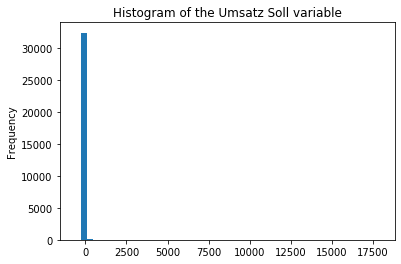

In [45]:
import seaborn as sns

data_2_prep['Umsatz Soll'].plot.hist(
    bins = 50,
    title = "Histogram of the Umsatz Soll variable"
)


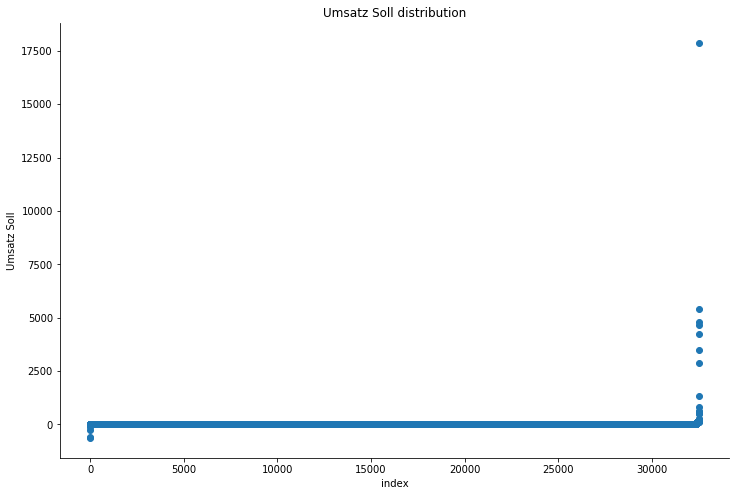

In [58]:
plt.figure(figsize=(12,8))
plt.scatter(range(data_2_prep.shape[0]), np.sort(data_2_prep['Umsatz Soll'].values))
plt.xlabel('index')
plt.ylabel('Umsatz Soll')
plt.title("Umsatz Soll distribution")
sns.despine()

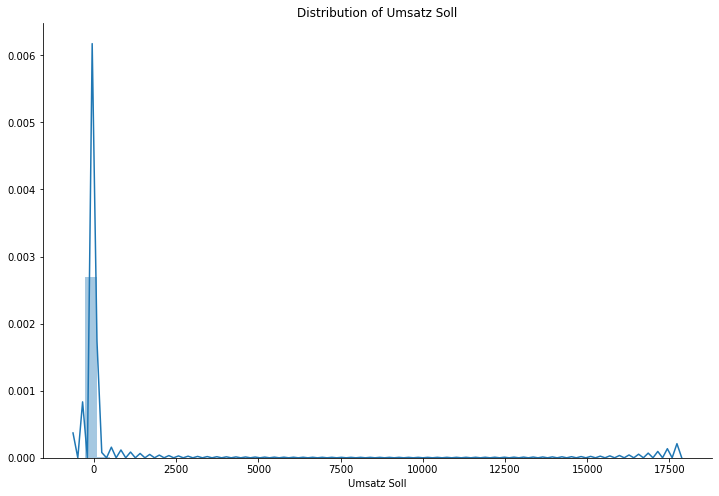

In [52]:
plt.figure(figsize=(12,8))
sns.distplot(data_2_prep['Umsatz Soll'])
plt.title("Distribution of Umsatz Soll")
sns.despine()

In [55]:
print("Skewness: ", data_2_prep['Umsatz Soll'].skew())
print("Kurtosis: ", data_2_prep['Umsatz Soll'].kurt())

Skewness:  122.13981050013857
Kurtosis:  17634.595794919525


In [39]:
# data_2_prep = data_2_prep[data_2_prep['Umsatz Haben'] < 7500]
# data_2_prep = data_2_prep[data_2_prep['Umsatz Haben'] > -200]
# data_2_prep.describe()

To visualize the problem let's reduce the data to 2D. The ground truth is Umsatz Soll = 0.00.

As expected there are many other values not equal to zero.

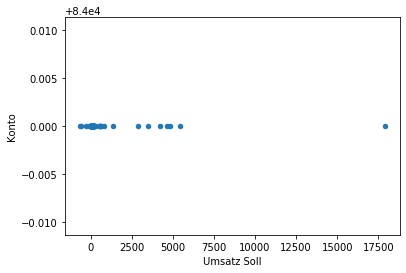

In [40]:
soll_haben = data_2_prep[["Umsatz Soll", "Konto"]]
soll_haben.plot.scatter(x = "Umsatz Soll", y = "Konto")

Let's scale the data.

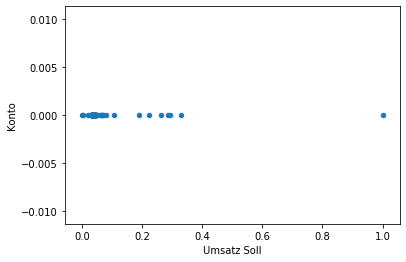

In [41]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
soll_haben = scaler.fit_transform(soll_haben)
soll_haben = pd.DataFrame(soll_haben, columns = ["Umsatz Soll", "Konto"])
soll_haben.plot.scatter(x = "Umsatz Soll", y = "Konto")

And the DBSCAN:

In [42]:
from sklearn.cluster import DBSCAN
outlier_detection = DBSCAN(
    eps = 0.001,
    metric="euclidean",
    min_samples = 10,
    n_jobs = -1)

clusters = outlier_detection.fit_predict(soll_haben)

DBSCAN detected the outliiers.

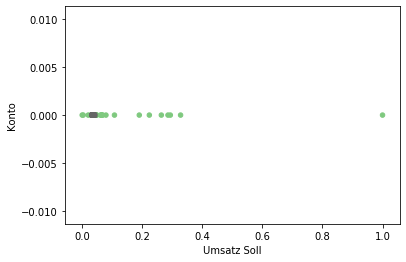

In [43]:
from matplotlib import cm
cmap = cm.get_cmap('Accent')
soll_haben.plot.scatter(
    x = "Umsatz Soll",
    y = "Konto",
    c = clusters,
    cmap = cmap,
    colorbar = False
)

Let's see how many clusters DBSCAN build and what are the data points from outliers cluster (-1).

In [44]:
from collections import Counter
outlier_df = pd.DataFrame(data_2_prep)
print(Counter(outlier_detection.labels_), '\n')
print(outlier_df[outlier_detection.labels_ == -1])

Counter({0: 32497, -1: 26}) 

       Konto  Gegenkonto  Steuersatz  Umsatz Soll  Umsatz Haben     date_unix  \
29     84000      116010       19.00       260.96          0.00 1518134400.00   
31     84000      102020       19.00       568.15          0.00 1518998400.00   
32     84000      126010       19.00       633.76          0.00 1519257600.00   
3557   84000      120000       19.00       184.87          0.00 1519344000.00   
3558   84000      120000       19.00       170.59          0.00 1519776000.00   
3559   84000      120000       19.00       162.18          0.00 1518566400.00   
10413  84000      120000       19.00       251.26          0.00 1522108800.00   
15170  84000      116010       19.00      -260.96          0.00 1518134400.00   
15172  84000      126010       19.00      -633.76          0.00 1519257600.00   
19926  84000      118020       19.00      2885.00          0.00 1528243200.00   
19934  84000      106010       19.00       550.00          0.00 1530662400.00  